# Overview

**Generates Figure 3, 4, 5 and 6 for manuscript. The figures illustrate the peak detection capabilities of the CNN model and the SG method.**

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
#physical_devices = tf.config.list_physical_devices('GPU')
#try:
#    tf.config.experimental.set_memory_growth(physical_devices[0], True)
#except:
#    pass

import sys
sys.path.append('../src/')

# import cnn modules
from cnn.simulator import Simulator
from cnn.models import ConvNet
from cnn.preprocessing import LabelEncoder
from cnn.data_generators import DataGenerator

# If using these fonts dont work, no worries 
# (might give a warning later on, but falls back to other font)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

# path to save plots
save_path = 'output/plots/'

# Build model and predict
---

In [2]:
NUM_TRAIN_EXAMPLES = int(1e6)
NUM_TEST_EXAMPLES = int(1e4)

NUM_CLASSES = 3
NUM_WINDOWS = 256
INPUT_SIZE = 8192

label_encoder = LabelEncoder(NUM_WINDOWS)

test_generator = DataGenerator(
    np.arange(NUM_TRAIN_EXAMPLES, NUM_TRAIN_EXAMPLES + NUM_TEST_EXAMPLES), 
    simulator=Simulator(label_encoder.remove_collision, resolution=INPUT_SIZE, 
                        white_noise_prob=1.0), 
    label_encoder=label_encoder,
    batch_size=32,
    shuffle=False,
)

model = ConvNet(
    filters=[64, 128, 128, 256, 256],
    kernel_sizes=[9, 9, 9, 9, 9],
    dropout=0.0,
    pool_type='max',
    pool_sizes=[2, 2, 2, 2, 2],
    conv_block_size=1,
    input_shape=(INPUT_SIZE, 1),
    output_shape=(NUM_WINDOWS, NUM_CLASSES),
    residual=False
)

# If retraining, weights will based with name "weights_000", "weights_001" etc.
# depending on which epoch (weights are saved each epoch)
model.load_weights('output/weights/cnn_weights.h5')

prediction = model.predict(test_generator, verbose=1)

313/313 [==============================] - 116s 369ms/step


# Simulated chromatogram
---

## 3(A): Whole chromatogram

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


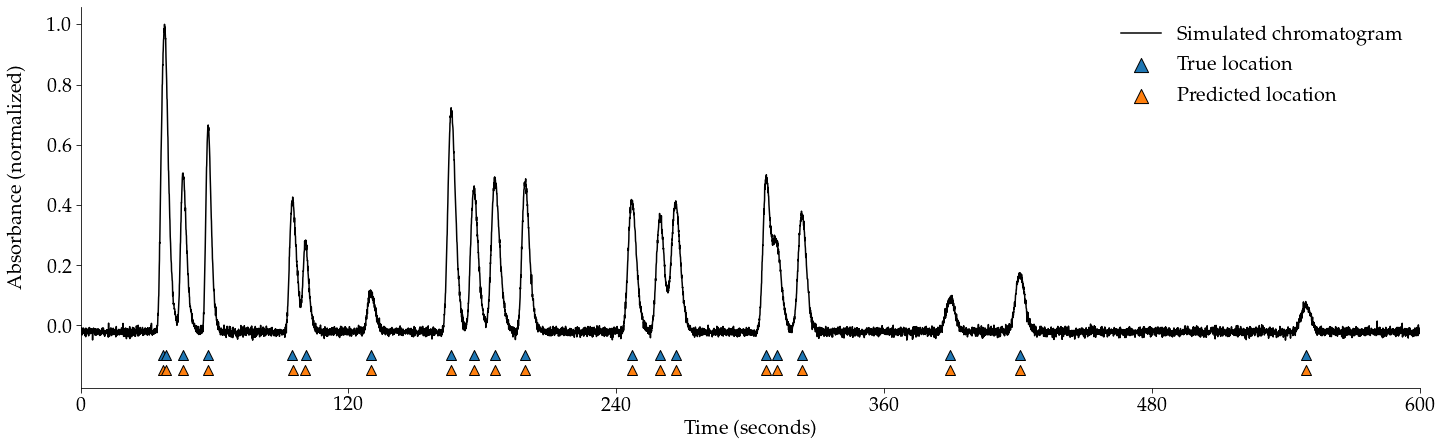

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(24, 7))

ID = 39

threshold = 0.5

x_lim = (0.0, 1.00)

# GROUND TRUTH
true = test_generator.__getitem__(ID)
pred = prediction[ID*test_generator.batch_size]
probs, locs, areas = label_encoder.decode(pred, threshold)

x = true[0][0]
y = true[1][0]

gt = label_encoder.decode(y)

j, k = 0, 0

for i, y_sample in enumerate(y):
    
    if y_sample[0] == 1:
        index = int(gt[1][k] * INPUT_SIZE)
        if x_lim[0] < gt[1][k] < x_lim[1]: 
            ax.scatter(gt[1][k], np.min(x)-0.05, c='C0', s=100, marker='^', edgecolor='black')
            
        k += 1
        
    if pred[i][0] > threshold:
        index = int(gt[1][k-1] * INPUT_SIZE)
        if x_lim[0] < locs[j] < x_lim[1]: 
            ax.scatter(locs[j], np.min(x)-0.1, c='C1', s=100, marker='^', edgecolor='black')
            
        j += 1
        
ax.plot(np.linspace(0, 1, INPUT_SIZE), x, c='black', label='Simulated chromatogram')
        
ax.scatter([None],[None], c='C0', marker='^', s=200, edgecolor='black', label='True location')
ax.scatter([None],[None], c='C1', marker='^', s=200, edgecolor='black', label='Predicted location')

ax.set_ylabel('Absorbance (normalized)', fontsize=20)
ax.set_xlabel('Time (seconds)', fontsize=20)
ax.set_xticklabels([0*60, 2*60, 4*60, 6*60, 8*60, 10*60])
ax.tick_params(axis='both', length=5, labelsize=20)
ax.yaxis.set_label_coords(-0.04, 0.55)
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax.legend(fontsize=20, frameon=False, ncol=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(*x_lim)
plt.savefig(save_path + 'Figure_3a.png', dpi=200)

## 3(B): Cropped chromatogram

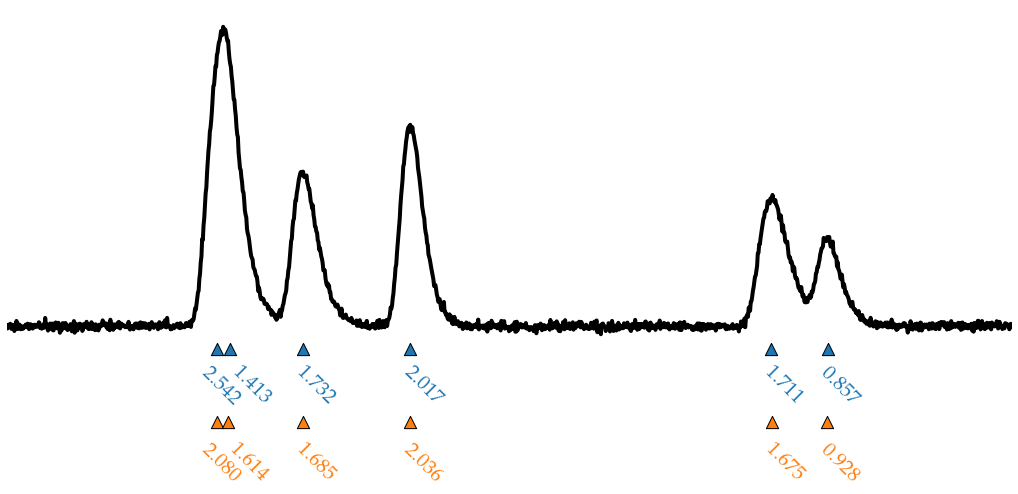

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))


x_lim = (0.025, 0.2)

# GROUND TRUTH
true = test_generator.__getitem__(ID)

pred = prediction[ID*test_generator.batch_size]

probs, locs, areas = label_encoder.decode(pred, threshold)

x = true[0][0]
y = true[1][0]

gt = label_encoder.decode(y)

ax.plot(np.linspace(0, 1, INPUT_SIZE), x, c='black', linewidth=4)
ax.set_xlim(*x_lim)
ax.axis('off')

j, k = 0, 0
for i, y_sample in enumerate(y):
    
    if y_sample[0] == 1:
        
        if k == 0:
            move = 0.0015
        elif k == 1:
            move = -0.0015
        # ...
        else:
            move = 0
        
        index = int(gt[1][k] * INPUT_SIZE)
        if np.linspace(0, 1, INPUT_SIZE)[index] > x_lim[1]:
            continue

        if x_lim[0] < gt[1][k] < x_lim[1]: 
            ax.scatter(gt[1][k], np.min(x)-0.05, c='C0', s=150, marker='^', edgecolor='black')
            ax.text(x=gt[1][k]-0.0100 * (x_lim[1] - x_lim[0]) - move, 
                    y=-0.285, 
                    s=f"{gt[2][k]:.3f}", 
                    rotation=-45, 
                    color="C0", 
                    fontsize=20)
        
        k += 1
    
    index = int(gt[1][k-1] * INPUT_SIZE)
    if np.linspace(0, 1, INPUT_SIZE)[index] > x_lim[1]:
        continue
            
    if pred[i][0] > threshold:
            
        if x_lim[0] < locs[j] < x_lim[1]: 
            
            ax.scatter(locs[j], np.min(x)-0.3, c='C1', s=150, marker='^', edgecolor='black')
            ax.text(x=locs[j]-0.0100 * (x_lim[1] - x_lim[0]) - move, 
                    y=-0.550, 
                    s=f"{areas[j]:.3f}", 
                    rotation=-45, 
                    color='C1', 
                    fontsize=20)

        j += 1
        
ax.set_ylabel('Absorbance (normalized)', fontsize=20)
ax.set_xlabel('Time (seconds)', fontsize=20)


plt.savefig(save_path + 'Figure_3b.png', dpi=200)

# Experimental (real) chromatograms
---

## Define helper functions to plot figures

In [5]:
def apply_interpolation(x, y, target_size):
    from scipy.interpolate import interp1d
    # Obtain interpolation function (input original x (time) and y (signal))
    f = interp1d(x, y)
    # Create new x (same x_min and x_max but different number of data points)
    x_new = np.linspace(x.min(), x.max(), target_size)
    # Obtain new y (based on new x)
    y_new = f(x_new)
    # return both new x and new y
    return x_new, y_new

def plot_individual_peaks(ax, path, adjust=None):
    
    from scipy.signal import find_peaks
    
    if isinstance(path, str):
        path = glob.glob(path)
    
    for i, file_path in enumerate(path):
        
        # Read csv file
        data = pd.read_csv(file_path, header=None, sep='\t', encoding='utf-16')
        
        # Apply interpolation (so that the CNN can perform peak detecetion)
        time, signal = apply_interpolation(data[0], data[1], INPUT_SIZE) 
        
        # To simple peak detection in order to get the region of the peak 
        # This is merely done for prettier visualization
        detect = find_peaks(signal, height=signal.max()/2, width=0.1)
        idx = np.argmax(detect[1]['widths'])
        apex = detect[0][idx]
        width = detect[1]['widths'][idx] * 2
        
        # Figure 5 have shifted indivudal peaks, adjust=True will correct it
        # (only to be used for Figure 5)
        if adjust is not None:
            move = time[apex] * 0.01
        else:
            move = 0
            
        # Plotting happens here
        ax.plot(
            time[apex-int(width): apex+int(width*1.2)]+move, 
            signal[apex-int(width): apex+int(width*1.2)], linewidth=2,
            c='black', label='Individual peaks' if i == 0 else None
        )

def plot_predictions(ax, model, chromatogram, time, threshold, move, labels):
    
    # Obtain predictions (chromatogram needs dim (1, 8192, 1)) and normalization
    predictions = model.predict(chromatogram[None, :, None]  / chromatogram.max())[0]
    
    # Obtain predicted probs, locs and areas 
    probs, locs, areas = label_encoder.decode(predictions, threshold)
    
    # Loop over predictions
    for i, (prob, loc, area) in enumerate(zip(probs, locs, areas)):
        
        # Get original loc 
        loc_modified = loc * time.max()
        y = chromatogram.min() - chromatogram.max() * 0.05
        ax.scatter(loc_modified, y, 
                        color='C1', marker='^', s=100, edgecolors='black', 
                        label="Predicted\nlocations (CNN)" if i == 0 else None)
        
        y = chromatogram.min() - chromatogram.max() * 0.225
        ax.text(x=loc_modified + move[i], y=y, 
                     s=f'{prob:.3f}', rotation=-45, fontsize=16)
        
    for label in labels:
        ax.text(x=label[1][0], y=label[1][1], s=label[0], fontsize=20)
        
def modify_axis(fig, ax1, ax2, x_lim):
    # Modify top subplot
    ax1.set_xlim(*x_lim)
    ax1.set_xticklabels([]) 
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.tick_params(axis='both', which='both', labelsize=20, length=5)
    ax1.set_ylabel('Absorbance (mAU)', fontsize=20)
    ax1.yaxis.set_label_coords(-0.04, 0.6)
    y_lim = ax1.get_ylim()
    ax1.set_ylim(y_lim[0] - y_lim[1]*0.15, y_lim[1])
    
    # Ugly way to remove negative values from subplot (top one)
    fig.canvas.draw() # in order to make yticklabels visible
    labels = [item.get_text() for item in ax1.get_yticklabels()]
    new_labels = []
    for l in labels:
        if l.strip('$')[0] != '-':
            new_labels.append(float(l.strip('$')))
    ax1.set_yticks(new_labels)
    
    # Modify bottom subplot
    ax2.spines['right'].set_visible(False)
    ax2.tick_params(axis='both', which='both', labelsize=20, length=5)
    ax2.set_xlabel('Time (min)', fontsize=20)
    ax2.set_xlim(*x_lim)
    
    # Set legend (a bit complicated as we want a single legend on top)
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2
    
    fig.legend(handles, labels, 
               bbox_to_anchor=(0, 0, 0.85, 0.99), fontsize=18, frameon=False, ncol=5)


def plot_derivative_and_predictions(ax, chrom_orig, time_orig, window_length, polyorder=2, **kwargs):
    
    from scipy.signal import savgol_filter, find_peaks
    
    # Perform SG smoothing
    deriv = savgol_filter(chrom_orig, window_length, polyorder, deriv=2)
    
    # Plot second order derivative (in green)
    ax.plot(time_orig, deriv, c='C2', linewidth=2, label='Second\nderivative')
    
    # Obtain predicted locatiosn (based on derivative; in green triangles)
    height = np.max(np.abs(deriv))
    locs = find_peaks(-deriv, **kwargs)[0]

    # Set new ylim
    y_lim = list(ax.get_ylim())
    y_lim[0] -= abs(max(*y_lim)) * 1.2
    y_lim[1] += abs(max(*y_lim)) * 0.4
    ax.set_ylim(*y_lim)
        
    # Loop over predicted locs
    for i, loc in enumerate(locs):
        y = deriv.min() - max(np.abs(deriv)) * 0.4
        ax.scatter(time_orig[loc], y, marker='^', s=100, 
                   edgecolors='black', c=f'C2',
                   label='Predicted\nlocations (SG)' if i == 0 else None)
        
    # remove y axis of subplot
    ax.yaxis.set_visible(False)

# Figure 4

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


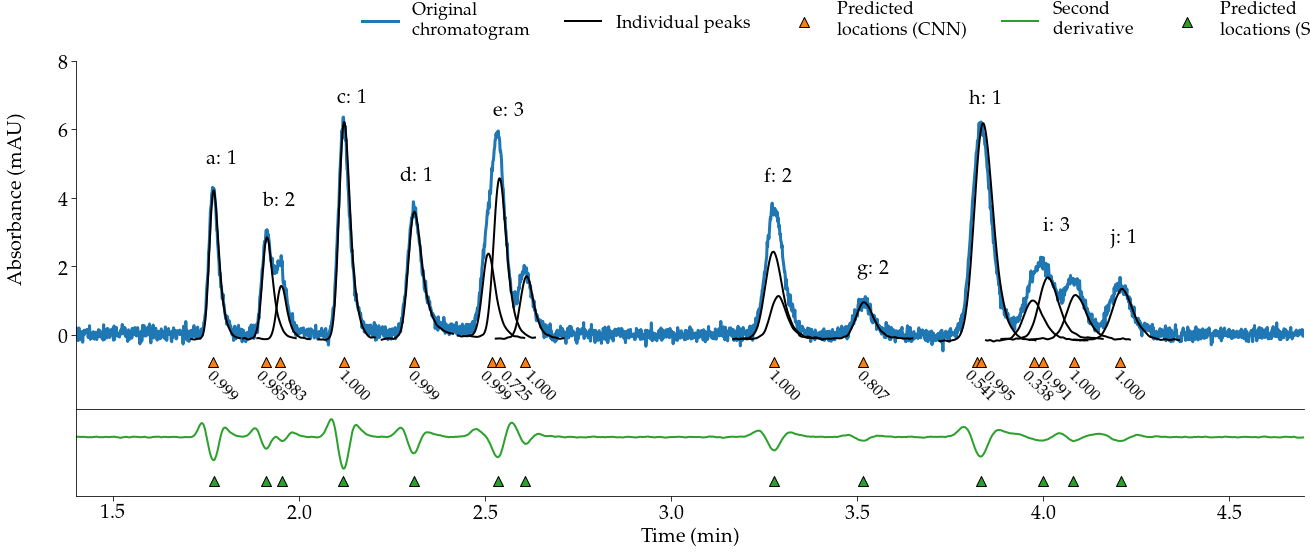

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(22, 8), 
                         gridspec_kw={'height_ratios': [4, 1]})

data = pd.read_csv('../input/chrom_1/ISO_ALL_F160.CSV', header=None, sep='\t', encoding='utf-16')

time, chromatogram = apply_interpolation(data[0], data[1], INPUT_SIZE)

# Plot original chromatogram (in blue)
axes[0].plot(time, chromatogram, c='C0', linestyle='-', linewidth=3, label='Original\nchromatogram')

# MOVE PROBABILITY VALUES (TO AVOID OVERLAP)
move = [
    -0.025, -0.035, -0.020, -0.025, -0.025, -0.040, -0.010, -0.010, -0.025, -0.025,
    -0.045, -0.005, -0.040, -0.015, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025,
]

# ADD LABELS TO PLOT
labels = [
    ('a: 1', (1.75, 5.0)), 
    ('b: 2', (1.9,  3.8)), 
    ('c: 1', (2.1,  6.78)), 
    ('d: 1', (2.27, 4.5)), 
    ('e: 3', (2.52,  6.43)),
    ('f: 2', (3.25,  4.5)), 
    ('g: 2', (3.5,  1.8)), 
    ('h: 1', (3.8,  6.73)),
    ('i: 3', (4.0,   3.05)),
    ('j: 1', (4.18,  2.7))
]

# plot predictions (triangles + probs)
plot_predictions(axes[0], model, chromatogram, time, 0.3, move, labels)

# Plot actual individual peaks (in black)
plot_individual_peaks(axes[0], '../input/chrom_1/ISO_[0-9]*')

# Plot derivatives and predicted locations based on that (SG method)
plot_derivative_and_predictions(axes[1], data[1], data[0], window_length=601, polyorder=2,
                                height=0.00001, distance=data[1].shape[0] / 256)

# Modify axes to make plot nicer
modify_axis(fig, axes[0], axes[1], x_lim=(1.4, 4.7))

plt.subplots_adjust(hspace=0.0)
plt.savefig(save_path + 'Figure_4.png', dpi=200)


## Figure 5

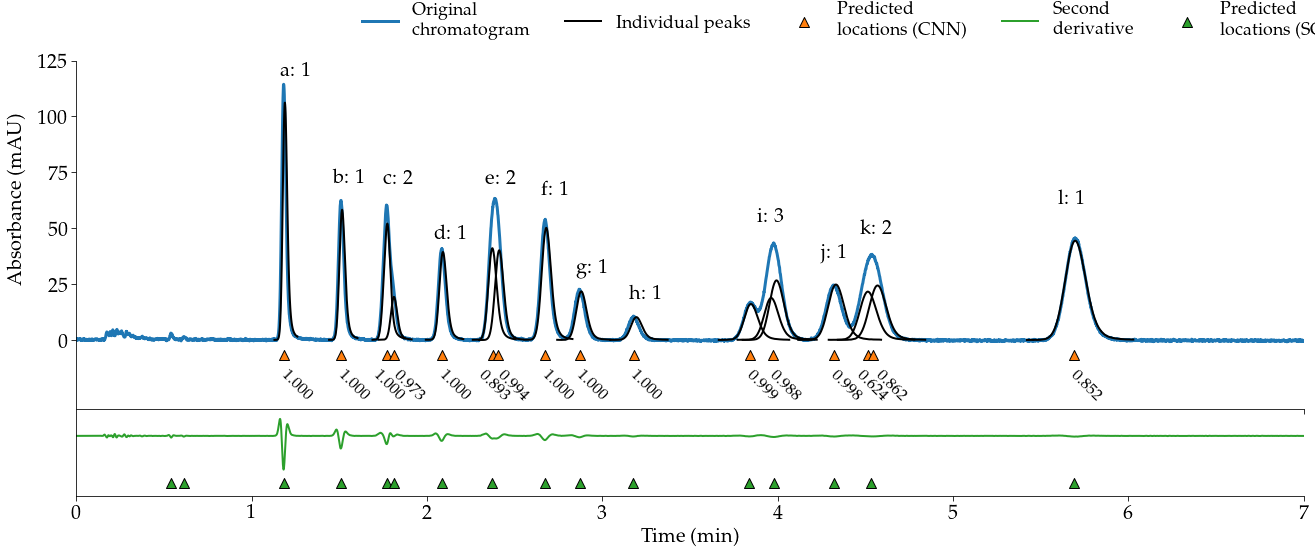

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(22, 8), 
                         gridspec_kw={'height_ratios': [4, 1]})

data = pd.read_csv('../input/ISO40_noisy/MIX_ISO40_F160.CSV', header=None, sep='\t', encoding='utf-16')

time, chromatogram = apply_interpolation(data[0], data[1], INPUT_SIZE)
#chromatogram += np.random.randn(chromatogram.shape[0]) * 0.1

# Plot original chromatogram (in blue)
axes[0].plot(time, chromatogram, c='C0', linestyle='-', linewidth=3, label='Original\nchromatogram')

# MOVE PROBABILITY VALUES (TO AVOID OVERLAP)
move = [
    -0.035, -0.035, -0.095, -0.015, -0.035,  -0.095, -0.015, -0.035, -0.035, -0.035,
    -0.035, -0.035, -0.035, -0.075,  0.000, -0.035, -0.035, -0.035, -0.035, -0.035,
]

# ADD LABELS TO PLOT
labels = [
    ('a: 1', (1.16, 118)), 
    ('b: 1', (1.46, 70)), 
    ('c: 2', (1.75, 70)), 
    ('d: 1', (2.04, 45)), 
    ('e: 2', (2.33, 70)),
    ('f: 1', (2.65, 65)), 
    ('g: 1', (2.85, 30)), 
    ('h: 1', (3.15, 18)),
    ('i: 3', (3.88, 53)),
    ('j: 1', (4.24, 37)),
    ('k: 2', (4.47, 48)),
    ('l: 1', (5.60, 61)),
]

plot_predictions(axes[0], model, chromatogram, time, 0.5, move, labels)

# Plot actual individual peaks (in black)
plot_individual_peaks(axes[0], '../input/ISO40_noisy/[XVI0-9]*.CSV', adjust=True)
        
# Plot derivatives and predicted locations based on that (SG method)
plot_derivative_and_predictions(axes[1], data[1], data[0], window_length=241, polyorder=2,
                                height=0.0001, width=data[1].shape[0] / 600, distance=data[1].shape[0] / 256)

# Modify axes to make plot nicer
modify_axis(fig, axes[0], axes[1], x_lim=(0.0, 7.0))

plt.subplots_adjust(hspace=0.0)
plt.savefig(save_path + 'Figure_5.png', dpi=200)

## Figure 6

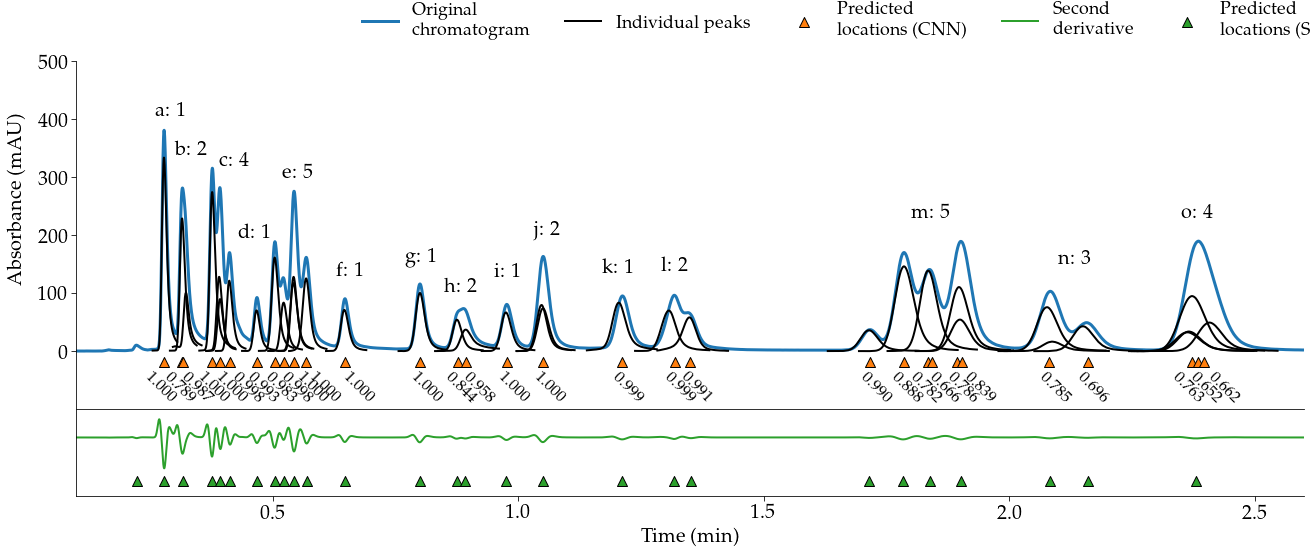

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(22, 8), 
                         gridspec_kw={'height_ratios': [4, 1]})

data = pd.read_csv('../input/ISO30B_mixed/MIX_ISO30B.CSV', header=None, sep='\t', encoding='utf-16')

time, chromatogram = apply_interpolation(data[0], data[1], INPUT_SIZE)
#chromatogram += np.random.randn(chromatogram.shape[0]) * 1

# Plot original chromatogram (in blue)
axes[0].plot(time, chromatogram, c='C0', linestyle='-', linewidth=3, label='Original\nchromatogram')

# ADD LABELS TO PLOT
labels = [
    ('a: 1', (0.26, 405)), 
    ('b: 2', (0.30, 340)), 
    ('c: 4', (0.39, 320)), 
    ('d: 1', (0.43, 195)), 
    ('e: 5', (0.52, 300)),
    ('f: 1', (0.63, 130)), 
    ('g: 1', (0.77, 155)), 
    ('h: 2', (0.85, 102)),
    ('i: 1', (0.95, 128)),
    ('j: 2', (1.03, 200)),
    ('k: 1', (1.17, 135)),
    ('l: 2', (1.29, 140)),
    ('m: 5', (1.80, 230)),
    ('n: 3', (2.10, 150)),
    ('o: 4', (2.35, 230)),
]

# MOVE PROBABILITY VALUES (TO AVOID OVERLAP)
move = [
    -0.045, -0.040, -0.010, -0.035, -0.015, -0.000, -0.025, -0.025, -0.010,  0.000,
    0.000, -0.010, -0.025, -0.030, -0.01, -0.025, -0.025, -0.025, -0.025, -0.025,
    -0.025, -0.030, -0.040, -0.010, -0.025, -0.000, -0.025, -0.025, -0.045, -0.02,
    0.005, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025,
]
plot_predictions(axes[0], model, chromatogram, time, 0.6, move, labels)

# Plot actual individual peaks (in black)
plot_individual_peaks(axes[0], '../input/ISO30B_mixed/[XVIL0-9]*.CSV')
        
# Plot derivatives and predicted locations based on that (SG method)
plot_derivative_and_predictions(axes[1], data[1], data[0], window_length=45, polyorder=2,
                                height=0.01, width=data[1].shape[0] / 500, distance=data[1].shape[0] / 256)


# Modify axes to make plot nicer
modify_axis(fig, axes[0], axes[1], x_lim=(0.1, 2.6))

plt.subplots_adjust(hspace=0.0)
plt.savefig(save_path + 'Figure_6.png', dpi=200)



In [9]:
# fig, axes = plt.subplots(2, 1, figsize=(22, 8), 
#                          gridspec_kw={'height_ratios': [4, 1]})

# data = pd.read_csv('../input/ISO30A_mixed/MIX_ISO30A.CSV', header=None, sep='\t', encoding='utf-16')

# time, chromatogram = apply_interpolation(data[0], data[1], INPUT_SIZE)
# #chromatogram += np.random.randn(chromatogram.shape[0]) * 1

# # Plot original chromatogram (in blue)
# axes[0].plot(time, chromatogram, c='C0', linestyle='-', linewidth=3, label='Original\nchromatogram')

# # Plot predicted peaks (represented as orange triangles, with prob values)
# # Modify location of prob values vi200a move to avoid overlapping text 
# # (move has to be set manually)
# move = [
#     -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025,
#     -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025,
#     -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025,
#     -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025,
# ]
# labels = [
#     ('a: 2', (0.25, 475)), 
#     ('b: 2', (0.30, 360)), 
#     ('c: 5', (0.40, 320)), 
#     ('d: 1', (0.44, 225)), 
#     ('e: 4', (0.53, 200)),
#     ('f: 1', (0.63, 120)), 
#     ('g: 1', (0.77, 155)), 
#     ('h: 1', (0.86, 75)),
#     ('i: 1', (0.95, 100)),
#     ('j: 1', (1.03, 125)),
#     ('k: 1', (1.17, 125)),
#     ('l: 1', (1.27, 115)),
#     ('m: 3', (1.39, 410)),
#     ('n: 2', (1.73, 190)),
#     ('o: 1', (1.87, 95)),
#     ('p: 3', (2.06, 180)),
#     ('q: 4', (2.35, 230)),
# ]
# plot_predictions(axes[0], model, chromatogram, time, 0.50, move, labels=labels)

# # Plot actual individual peaks (in black)
# plot_individual_peaks(axes[0], '../input/ISO30A_mixed/[XVIL0-9]*.CSV')

        
# # Plot derivatives and predicted locations based on that (SG method)
# plot_derivative_and_predictions(axes[1], data[1], data[0], window_length=45, polyorder=2,
#                                 height=0.01, width=data[1].shape[0] / 500, distance=data[1].shape[0] / 256)


# # Modify axes to make plot nicer
# modify_axis(fig, axes[0], axes[1], x_lim=(0.0, 3.0))

# plt.subplots_adjust(hspace=0.0)
# plt.savefig(save_path + 'Figure_7.png', dpi=200)

In [10]:
# fig, axes = plt.subplots(2, 1, figsize=(22, 8), 
#                          gridspec_kw={'height_ratios': [4, 1]})


# ortho = ["58","05","38","67","04","81","69","68","33","93"]
# meta  = ["55","60","59","26","78","17","63","40","30","25"]
# para  = ["71","82","76","12","62","39","31","37","51","35"]

# regex = set(para + ortho)
# files = ['../input/OLD_AE_DATA/ISO/ISO_5_PPM_' + r + '.CSV' for r in regex]

# data = pd.read_csv('../input/OLD_AE_DATA/ISO/ISO_5_PPM_F10_ORTHO&PARA.CSV', header=None, sep='\t', encoding='utf-16')

# time, chromatogram = apply_interpolation(data[0], data[1], INPUT_SIZE)

# # Plot original chromatogram (in blue)
# axes[0].plot(time, chromatogram, c='C0', linestyle='-', linewidth=2, label='Original\nchromatogram')

# # Plot predicted peaks (represented as orange triangles, with prob values)
# # Modify location of prob values via move to avoid overlapping text 
# # (move has to be set manually)
# move = [
#     -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025,
#     -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025,
#     -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025,
#     -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025, -0.025,
# ]
# plot_predictions(axes[0], model, chromatogram, time, 0.5, move)

# # Plot actual individual peaks (in black)
# plot_individual_peaks(axes[0], files)

        
# # Plot derivatives and predicted locations based on that (SG method)
# plot_derivative_and_predictions(axes[1], data[1], data[0], window_length=45, polyorder=2,
#                                 height=0.0005, width=data[1].shape[0] / 500, distance=data[1].shape[0] / 256)


# # Modify axes to make plot nicer
# modify_axis(fig, axes[0], axes[1], x_lim=(1.0, 5.0))

# plt.subplots_adjust(hspace=0.0)
# plt.savefig(save_path+'Figure_8.png', dpi=200)